# Regional MFD

## Instructions

1. **Install solvis**

```
$ git clone https://github.com/GNS-Science/solvis.git
$ pip install matplotlib
$ pip install -r solvis/requirements.txt
$ pip install -e solvis
```

2. **Download an Inversion Solution zip file and specify its path**



In [1]:
inversion_solution_file = '/home/chrisdc/Downloads/NZSHM22_InversionSolution-QXV0b21hdGlvblRhc2s6MTA3MTQ3.zip'

3. **Define a region**

    1. go to __[geojson.io](http://geojson.io)__
    2. draw a poloygon and copy the resulting geojson output
    3. copy the geojason to a file (e.g. `poly1.geojson`) 
    4. specify the path to your geojson polygon

In [2]:
poly_file = '/home/chrisdc/NSHM/DEV/scripts/regional_mfd/data/poly1.geojson'

4. **Run the notebook**

In [3]:
import geopandas
from zipfile import ZipFile
import matplotlib.pyplot as plt
from solvis import *
import math
import numpy as np
import shapely.geometry

In [4]:
def degToRad(a):
    return math.pi/180.0 * a

def radToDeg(a):
    return 180.0 / math.pi * a

def calcAzimuth(line):
    lon1,lat1,lon2,lat2 = [(math.pi/180.0)*x for x in line.bounds]
    dlon = lon2-lon1
    return math.atan2(math.sin(dlon)*math.cos(lat2), math.cos(lat1)*math.sin(lat2)-math.sin(lat1)*math.cos(lat2)*math.cos(dlon))

def getDownDipPoint(lat,lon,dip_dir,x):
    R = 6371.0
    Ad = x/R
    latdd = math.asin(math.sin(lat)*math.cos(Ad)+math.cos(lat)*math.sin(Ad)*math.cos(dip_dir))
    londd = lon + math.atan2(math.sin(dip_dir)*math.sin(Ad)*math.cos(lat),math.cos(Ad)-math.sin(lat)*math.sin(lat))
    return(latdd,londd)

def getFaultPatchPoly(line,height,dip):
    lon1,lat1,lon2,lat2 = [(math.pi/180.0)*x for x in line.bounds]
    dip_dir = calcAzimuth(line) + math.pi/2
    x = height / math.tan(dip*math.pi/180.0)
    lat1dd,lon1dd = getDownDipPoint(lat1,lon1,dip_dir,x)
    lat2dd,lon2dd = getDownDipPoint(lat2,lon2,dip_dir,x)
    return shapely.geometry.Polygon([ [radToDeg(lon1), radToDeg(lat1)],\
        [radToDeg(lon2), radToDeg(lat2)],\
        [radToDeg(lon2dd), radToDeg(lat2dd)],\
        [radToDeg(lon1dd), radToDeg(lat1dd)] ])


In [5]:
def calcCumMFD(rates):
    cumrate = np.zeros(rates.shape)
    nbins = len(cumrate)
    for i in range(nbins):
        for j in range(i,nbins):
            cumrate[i] += rate[j]
    return cumrate



In [6]:

with ZipFile(inversion_solution_file, 'r') as zip:
    fault_sections_file = zip.open('ruptures/fault_sections.geojson')
    fault_sections = geopandas.read_file(fault_sections_file)

ncols = fault_sections.shape[0]
for (index, row) in fault_sections.iterrows():
    dip = row.DipDeg
    height = row.LowDepth - row.UpDepth
    line = row['geometry']
    fault_sections.loc[index,'geometry'] = getFaultPatchPoly(line,height,dip)




In [7]:
poly1 = geopandas.read_file(poly_file)
nz = geopandas.read_file('./data/nz-coastlines-and-islands-polygons-topo-150k/nz-coastlines-and-islands-polygons-topo-150k.shp')


sol = InversionSolution().from_archive(inversion_solution_file)
riw = sol.get_ruptures_intersecting(poly1.iloc[0]['geometry'])
rr = sol.ruptures_with_rates
mfd = mfd_hist(rr[rr["Rupture Index"].isin(list(riw))])
rate = np.asarray(mfd)
rate_cum = calcCumMFD(rate)
mag = [a.mid for a in mfd.index]

In [8]:
def set_plot_formatting():    
    # set up plot formatting
    SMALL_SIZE = 12
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 25

    plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


set_plot_formatting()

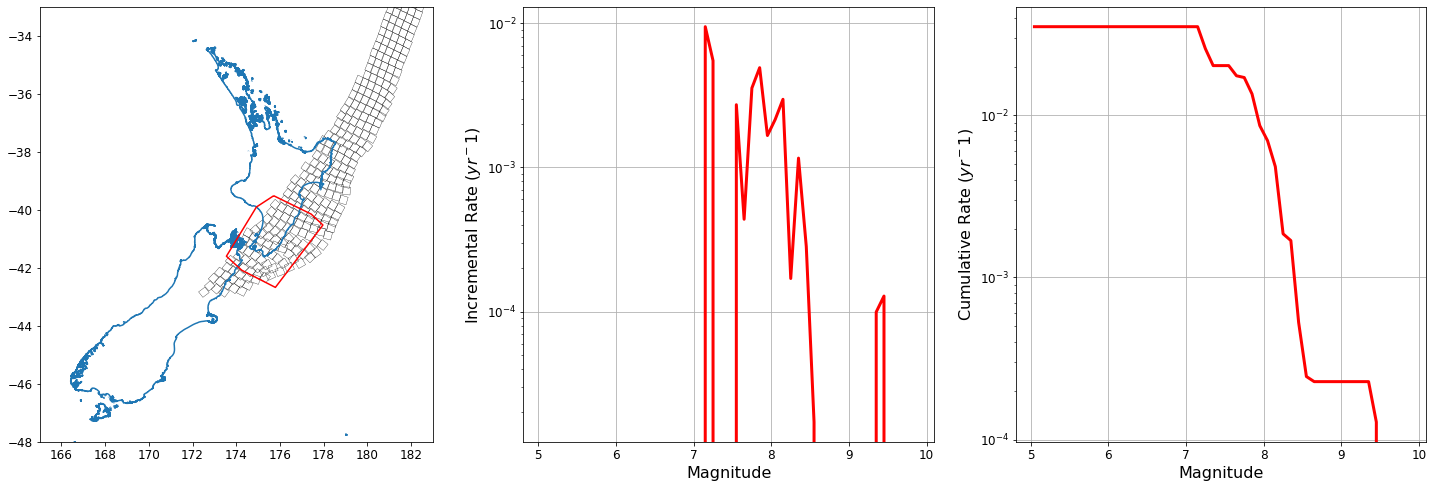

In [10]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(25,8)
fig.set_facecolor('white')

nz.boundary.plot(ax=ax[0])
fault_sections.plot(ax=ax[0],facecolor="none",edgecolor='black',linewidth=0.3)
poly1.boundary.plot(ax=ax[0],color='red')
ax[0].set_xlim([165,183])
ax[0].set_ylim([-48,-33])


ax[1].semilogy(mag,rate,color='red',linewidth=3)
ax[1].grid()
_ = ax[1].set(xlabel='Magnitude',ylabel='Incremental Rate ($yr^-1$)')

ax[2].semilogy(mag,rate_cum,color='red',linewidth=3)
ax[2].grid()
_ = ax[2].set(xlabel='Magnitude',ylabel='Cumulative Rate ($yr^-1$)')
